#Week 4 Assignment Questions


#Question 1.

**Overview:** This question provides you with practice implementing graphs in native Python.

**Point total:** ungraded, immediate feedback

**Time estimate:** 20 minutes.

Examine the example social network below (from [FMS Advanced Systems Group](http://www.fmsasg.com/SocialNetworkAnalysis/)). Create a variable named `graph` that represents this network using an **adjacency matrix** in native Python (not networkx). Calculate and display the degree of every node in the matrix.

![Example network](http://www.fmsasg.com/SocialNetworkAnalysis/SocialNetworkAnalysis_Degrees.gif)



In [1]:
import pprint
graph = { 'Mary': set (['Alice','Bob']),
          'Edgar' : set (['Alice','Frederica']),
          'Alice' : set (['Bob','Rafael','Frederica','Edgar','Mary']),
          'Frederica' :set ( ['Alice','Jim','Edgar']),
          'Bob' :set ( ['Rafael','Alice','Mary']),
          'Jim' : set (['Frederica','Rafael']),
          'Rafael' : set (['Aldo','Jim','Alice','Bob']),
          'Aldo' : set (['Stefan','Pierre','Rafael']),
          'Stefan' : set (['Aldo']),
          'Pierre' : set (['Aldo'])
    }
graphPrintable = pprint.pformat(graph)
print graphPrintable
for person in graph:
    print person,' is of degree ', len(graph[person])

{'Aldo': set(['Pierre', 'Rafael', 'Stefan']),
 'Alice': set(['Bob', 'Edgar', 'Frederica', 'Mary', 'Rafael']),
 'Bob': set(['Alice', 'Mary', 'Rafael']),
 'Edgar': set(['Alice', 'Frederica']),
 'Frederica': set(['Alice', 'Edgar', 'Jim']),
 'Jim': set(['Frederica', 'Rafael']),
 'Mary': set(['Alice', 'Bob']),
 'Pierre': set(['Aldo']),
 'Rafael': set(['Aldo', 'Alice', 'Bob', 'Jim']),
 'Stefan': set(['Aldo'])}
Aldo  is of degree  3
Stefan  is of degree  1
Rafael  is of degree  4
Frederica  is of degree  3
Pierre  is of degree  1
Bob  is of degree  3
Jim  is of degree  2
Mary  is of degree  2
Edgar  is of degree  2
Alice  is of degree  5


#Question 2.

**Overview:** This question provides you with practice representing and drawing graphs using networkx.

**Point total:** 5 points.

**Time estimate:** 30 minutes.

Represent the graph from Question 1 using networkx. Draw the graph.

Populating the interactive namespace from numpy and matplotlib


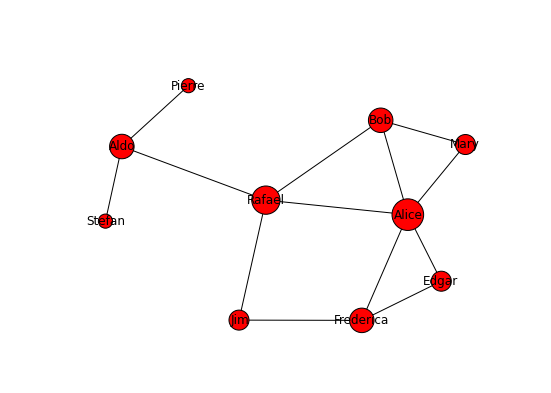

In [2]:
import networkx as nx

g = nx.Graph()


for person in graph:
    for friend in graph[person]:
        g.add_edge(person,friend)
        
%pylab inline
plt.rc('figure', figsize=(7,5))
d = nx.degree(g)
node_size = [v*200 for v in d.values()]
nx.draw(g,with_labels=True,nodelist=d.keys(),node_size=node_size)

#Question 3.

**Overview:** For this question, you will infer a graph of relationships between movies. Two movies will be connected if people rate them similarly. You will draw your graph using networkx.

**Point total:** 15 points.

**Time estimate:** 1 hour.


For this question, we'll infer a graph of related movies. Our graph will visualize relationships between movies in the [MovieLens 1 Million dataset](http://grouplens.org/datasets/movielens/) (a smaller dataset than the earlier one we studied). Run the following snippet of code to download and unzip the MovieLens 1M dataset.

In [24]:
import os
import urllib
import zipfile

# downloads the zip file
if not os.path.isfile('ml-1m.zip'):
    print('downloading ml-1m.zip...')
    data = urllib.urlopen('http://files.grouplens.org/datasets/movielens/ml-1m.zip').read()
    print('downloaded %d bytes' % len(data))
    f = open('ml-1m.zip', 'w')
    f.write(data)
    f.close()
    
# extracts the ratings.dat
if not os.path.isfile('ml-1m/ratings.dat'):
    print('extracting zip file.')
    zip = zipfile.ZipFile('ml-1m.zip')
    zip.extractall()


extracting zip file.


BadZipfile: Bad magic number for central directory

I've provided you with a series of helper functions below to interact with the movie data. The two most important functions for you are `get_cosimilarities()` and `read_titles()`.

In [3]:
from collections import defaultdict

def read_titles():
    """
        Returns a dictionary mapping movie ids to movie titles.
    """
    titles = {}
    for line in open('ml-1m/movies.dat'):
        (m, title, genres) = line.split('::')
        titles[int(m)] = title.decode('latin-1').encode('ascii', 'ignore')
    return titles

def get_cosimilarities():
    """
        Returns a cosimilarity matrix between movies with 1000 or more ratings.
        Cosimilarity values are average-adjusted cosine similarities between -1.0 and 1.0.
        The matrix has structure:
        
        {
            movieid1 : {
                movieid2 : 1.0,
                movieid2 : 0.5,
                movieid3 : 0.4,
                ....
            },
            movieid2 : {
                movieid1 : 0.5,
                movieid2 : 1.0,
                movieid3 : 0.9,
            },
            ...
        }
    """
    print('reading movie means...')
    means = get_movie_means(1000)
    print('read means for %d movies' % len(means))
    
    xdotx = defaultdict(lambda: defaultdict(float))
    xdoty = defaultdict(lambda: defaultdict(float))
    ydoty = defaultdict(lambda: defaultdict(float))
    
    users = read_users()
    for (i, u) in enumerate(users):
        if i % 500 == 0:
            print('processing user %d of %d' % (i, len(users)))
        good_movies = set(u.keys()).intersection(means.keys())
        for m1 in good_movies:
            x = u[m1] - means[m1]
            for m2 in good_movies:                
                y = u[m2] - means[m2]
                xdotx[m1][m2] += x * x
                ydoty[m1][m2] += y * y
                xdoty[m1][m2] += x * y
    
    print('building cosimilarity matrix')
    cosims = defaultdict(dict)
    for m1 in xdotx:
        for m2 in xdotx[m1]:
            sim = xdoty[m1][m2] / (xdotx[m1][m2] * ydoty[m1][m2]) ** 0.5
            cosims[m1][m2] = sim
    
    return cosims

def read_ratings():
    """
        A generator over movie ratings. 
        Each generated record represents a single movie rating with fields user, movie, rating, and timestamp.
    """
    f = open('ml-1m/ratings.dat')
    for line in f:
        (user, movie, rating, tstamp) = line.strip().split('::')
        yield { 'user' : int(user), 'movie' : int(movie), 'rating' : int(rating), 'tstamp' : tstamp }
    f.close()

def read_users():
    """
        Returns a list of users.
        Each user is a dictionary whose keys are movie ids (ints) and values are ratings (also ints).
    """
    users = defaultdict(dict)
    for rating in read_ratings():
        u = rating['user']
        m = rating['movie']
        r = rating['rating']
        users[u][m] = r
    return users.values()

def get_movie_means(min_ratings_per_movie):
    """
        Returns a dictionary mapping movie id to movie mean.
        Limits the returned movies to those with at least min_ratings_per_movie ratings.
    """
    sums = defaultdict(float)
    counts = defaultdict(int)
    for rating in read_ratings():
        m = rating['movie']
        r = rating['rating']
        sums[m] += r
        counts[m] += 1
    means = {}
    for m in counts:
        if counts[m] >= min_ratings_per_movie:
            means[m] = sums[m] / counts[m]
    return means
    

In [7]:
cosims_1 = cosims[1]
for w in sorted(cosims_1, key=cosims_1.get, reverse=True):
  print w, cosims_1[w]

1 1.0
3114 0.622414656026
2355 0.447343490594
588 0.429430587372
595 0.417039333773
364 0.390288838863
2081 0.365789838612
2407 0.356708073957
34 0.351801860798
2054 0.351208305132
2797 0.349073390977
1028 0.345119914469
1097 0.330957848219
1270 0.313897563847
2804 0.298734651899
2987 0.279327853999
2302 0.265346886313
1376 0.262740556544
2640 0.258552223872
919 0.255834331772
3751 0.252401976888
1198 0.252095552427
587 0.251945865933
3255 0.250878034604
150 0.248969987929
2012 0.244348619046
3175 0.243598987776
480 0.239079602943
2100 0.238043586199
39 0.234712801662
1961 0.234511189041
377 0.230562800094
1580 0.229304662144
1682 0.225264786522
2011 0.223012411383
1036 0.222972885664
356 0.220532235626
3361 0.220472100982
367 0.219595434326
1307 0.218359051003
2396 0.217300894247
1259 0.215977844114
1079 0.214857733369
2321 0.214795787156
1968 0.213775194475
2716 0.210266085285
2194 0.208598445715
589 0.20531193978
1387 0.201900775567
1356 0.201713917552
1197 0.200400959694
1291 0.200

You'll want to just build the cosimilarity matrix once, because it takes 30 seconds or so...

In [4]:
cosims = get_cosimilarities()

reading movie means...
read means for 207 movies
processing user 0 of 6040
processing user 500 of 6040
processing user 1000 of 6040
processing user 1500 of 6040
processing user 2000 of 6040
processing user 2500 of 6040
processing user 3000 of 6040
processing user 3500 of 6040
processing user 4000 of 6040
processing user 4500 of 6040
processing user 5000 of 6040
processing user 5500 of 6040
processing user 6000 of 6040
building cosimilarity matrix


Once the cosimilarity matrix is built, you can experiment with it. For example, the following bit of code displays the 10 movies with highest and lowest correlations.

In [17]:
def test_cosims(cosims):
    titles = read_titles()
    all_cors = []
    for m1 in cosims:
        for m2 in cosims[m1]:
            if m1 != m2:
                all_cors.append((cosims[m1][m2], m1, m2))

    # tuples are sorted by first element, which is cosimilarity
    all_cors.sort()
    
    # skip every other pair of movies because each pair shows up twice and sim(m1, m2) == sim(m2, m1)
    print('Lowest correlations:')
    for (sim, m1, m2) in all_cors[:20:2]:
        print('  %.3f: %s (%d)   <->   %s (%d)' %  (sim, titles[m1], m1, titles[m2], m2))

    all_cors.reverse()
    print('\nHighest correlations:')
    for (sim, m1, m2) in all_cors[:20:2]:
        print('  %.3f: %s (%d)   <->   %s (%d)' %  (sim, titles[m1], m1, titles[m2], m2))

test_cosims(cosims)

Lowest correlations:
  -0.216: Annie Hall (1977) (1230)   <->   Patriot, The (2000) (3753)
  -0.186: Air Force One (1997) (1608)   <->   Boogie Nights (1997) (1673)
  -0.185: Armageddon (1998) (1917)   <->   Rushmore (1998) (2395)
  -0.162: Ghost (1990) (587)   <->   This Is Spinal Tap (1984) (1288)
  -0.151: This Is Spinal Tap (1984) (1288)   <->   Armageddon (1998) (1917)
  -0.146: Edward Scissorhands (1990) (2291)   <->   Patriot, The (2000) (3753)
  -0.142: Annie Hall (1977) (1230)   <->   Green Mile, The (1999) (3147)
  -0.139: Citizen Kane (1941) (923)   <->   Lost World: Jurassic Park, The (1997) (1544)
  -0.137: True Lies (1994) (380)   <->   This Is Spinal Tap (1984) (1288)
  -0.135: Independence Day (ID4) (1996) (780)   <->   Annie Hall (1977) (1230)

Highest correlations:
  0.712: Godfather: Part II, The (1974) (1221)   <->   Godfather, The (1972) (858)
  0.703: Lethal Weapon 2 (1989) (2001)   <->   Lethal Weapon (1987) (2000)
  0.690: Austin Powers: The Spy Who Shagged Me (

Now that you have built the correlation matrix and understand how to use it, it's time to get to work!

***Your task:*** First, create a networkx graph capturing relationships between movies. Each movie should have an edge to its closest `n` neighbors. You can experiment with different values for `n` (I liked `n = 3`). Draw your graph using networkx.

***Hint:*** The algorithm will closely follow the last cell of code in Section 7 of the lecture notes.

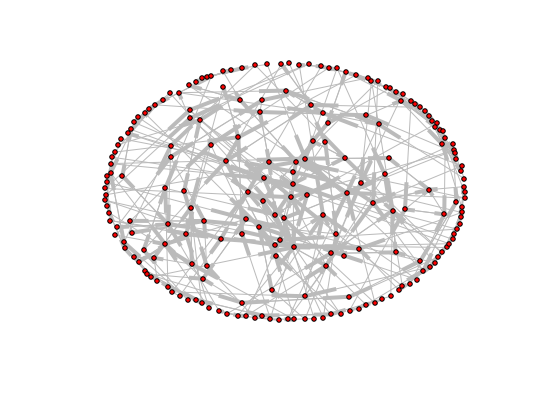

In [9]:
# This code works but uses the movie ids, not the movie titles.
import networkx as nx


g = nx.DiGraph()
for movie1 in cosims:
    neighbors = sorted(cosims[movie1], key=cosims[movie1].get, reverse=True)[:3]
    for movie2 in neighbors:
        g.add_edge(movie1, movie2)
nx.write_gml(g, 'movie_similiarity.gml')
nx.draw(g, node_size=20, edge_color='#bbbbbb')

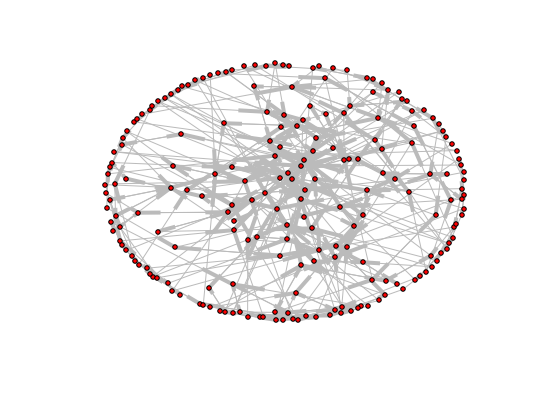

In [7]:
# This code works and adds movie titles.
import networkx as nx

movieTitles = read_titles()
g = nx.DiGraph()
for movie1 in cosims:
    neighbors = sorted(cosims[movie1], key=cosims[movie1].get, reverse=True)[:3]
    for movie2 in neighbors:
        g.add_edge(movieTitles[movie1],movieTitles[movie2])
nx.write_gml(g, 'movie_similiarity_with_movie_titles.gml')
nx.draw(g, node_size=20, edge_color='#bbbbbb')

#Question 4.

**Overview:** In this question you'll independent use Gephi to visualize and explore the movie graph.

**Time estimate:** 45 minutes.

**Point total:** 10.

Follow the procedure I demoed:

1. Import your networkx graph into Gephi following the procedure you learned in the lecture notes.
2. Color code the communities in the graph using the modularity partitioning.
3. Fine tune the graph and its layout so it is easy to read.
4. Upload a picture of your final graph (from the preview tab) to the course website.